# Assignment 2: Clustering California Housing with K-means

### CS 4774 Machine Learning - Department of Computer Science - University of Virginia
"Tonight, more than 130,000 Californians will go to sleep homeless. That’s enough to fill Dodger Stadium, AT&T Park and Petco Park. The biggest culprit is rising housing costs. From 2000 to 2014, median rent in California increased by more than one-third, while real incomes for renters fell by 7 percent. Today, 1.5 million Californians spend more than half their income on housing. This crisis threatens not just low-income families but our entire economy, driving businesses to relocate to states in which their employees can afford to live. - **Business Insider, Sep 2018.**"

![Half of the homes in San Franciso is now one million or above](https://www.travelinusa.us/wp-content/uploads/sites/3/2017/11/Painted-Ladies-San-Francisco-01.jpg).

In this assignment, you will attempt to cluster the California Housing by implementing and analyzing the k-means algorithm to the data. K-Means is one of the most popular clustering algorithms. K-means stores k-centroids that it uses to define clusters. A point is considered to be in a particular cluster if it is closer to that cluster's centroid than any other centroid. For references, you may refer to my lecture on K-means or Chapter 2 of the textbook if you need additional sample codes to help with your assignment. For deliverables, you must write code in Python and submit this Jupyter Notebook file (.ipynb) to earn a total of 100 pts. You will gain points depending on how you perform in the following sections.

**Note**: In order for your assignment to be graded, you must save your Notebook filename under this format: **yourUvaUserId_assignment_2_kmeans.ipynb**.


---
## 1. PRE-PROCESSING THE DATA (10 pts)

Download the California Housing dataset from the below link. This dataset includes statistics about the median income, median age, average number of rooms per person, average number of persons in a household etc. The statistics were gathered per geographical block.

**Data Acquiring:** Download the dataset from https://www.kaggle.com/camnugent/california-housing-prices

**Data Discovery, Visualization, and Cleaning:** Fortunately, this step have been given to you from chapter 2. However, you should review them and write the code necessary for the purposes of this assignment.

In [1]:
# You might want to use the following package
import pandas as pd
from pandas.plotting import scatter_matrix # optional
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.compose import ColumnTransformer
import numpy as np
from sklearn.model_selection import train_test_split 
from matplotlib import pyplot as plt

In [2]:
data_path = "./housing.csv"
data = pd.read_csv(data_path)

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [4]:
data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


C:\Users\fujos\AppData\Local\Temp\ipykernel_14396\1657988895.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  cormat = data.corr()


<Axes: >

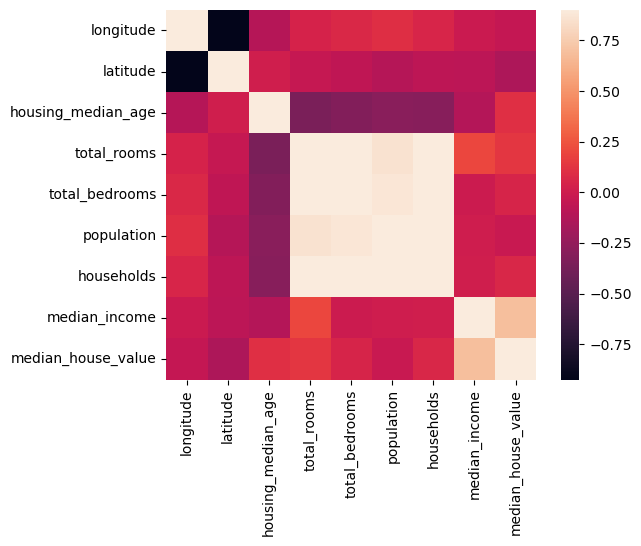

In [5]:
cormat = data.corr()
sns.heatmap(cormat, vmax=.9, square=True)

There are a couple features that have a strong linear correlation. We should keep this in mind as we are looking at the interpretation of our results. There may potentially be a skewing of the clustering towards these four features.

This is because we are scaling each of the features to have mean 0 and standard deviation 1, so clustering may be more biased towards these features that seem to be correlated.

We can consider making a meta feature on these features that are correlated as an extention of this assignment to address this issue.

In [6]:
categorical_variables = data.select_dtypes(include=['object']).columns.tolist()
quant_variables = data.select_dtypes(include='number').columns.to_list()

In [7]:
encodeCat = Pipeline([('impute', SimpleImputer(strategy='most_frequent')),('cat_label',OneHotEncoder(sparse_output=False))])
transformQuant = Pipeline([('impute', SimpleImputer(strategy='mean')), ('standard_scale', StandardScaler())])
feature_preprocess = ColumnTransformer(transformers = [
    ('categorical', encodeCat, categorical_variables), #
    ('quantitative', transformQuant, quant_variables)]
)
feature_preprocess.set_output(transform='pandas')
processed_data = feature_preprocess.fit_transform(data)

Here I contemplated splitting the data into a train and test set before processing the pipline on the train set and transforming the test set using the results. However, I decided just to process on the data as a whole. This is due to a couple reasons.

1. Our goal is not to predict new data points outside of the dataset.

2. Our goal is to use our data to deepen our understanding/interpretation of the clustering. From this perspective, having a test and training set didn't make sense to me.

- - -
## 2. IMPLEMENTING K-MEANS (40 pts)


In [8]:
# Function: K Means
# -------------
# K-Means is an algorithm that takes in a dataset and a constant
# k and returns k centroids (which define clusters of data in the
# dataset which are similar to one another).


#k is the number of clusers, p is the distance metric number, data is the data that needs to be classified
def k_mean(k, p, data):
    max_interation = 150
    iteration = 0
    centroids = 2*np.random.rand(k, len(data[0]))-1
    prev_centroid = None
    sorted_points = [[] for _ in range(k)]
    while np.not_equal(prev_centroid,centroids).any() and iteration < max_interation:
        #assign points to centroid
        sorted_points = [[] for _ in range(k)]
        for point in data:
            distance = np.power(np.sum(np.abs(np.power(point-centroids, p)), axis = 1),1/p)
            centroid_index = np.argmin(distance)
            sorted_points[centroid_index].append(point)
        
        #update centroid
        prev_centroid = centroids
        centroids = [np.mean(cluster, axis = 0) for cluster in sorted_points]
        for i, centroid in enumerate(centroids):
            if np.isnan(centroid).any(): 
                centroids[i] = prev_centroid[i]
        iteration += 1
    return sorted_points, centroids

- - -
## 3. CLUSTERING HOUSING INTO REGIONS (40 pts)


In [9]:
def inertia_std(sorted_points, centroids):
    sse = 0
    std = []
    for centroid_idx, points in enumerate(sorted_points):
        sumi = 0
        for point in points:
            distance_squared = np.sum(np.power(point-centroids[centroid_idx], 2))
            sse += distance_squared
            sumi += distance_squared
        sumi /= len(points)
        sumi = np.sqrt(sumi)
        std.append(sumi)
    return sse, std

In [10]:
sorted_pointsk2p2, centroidsk2p2 = k_mean(2, 2, processed_data.to_numpy())

In [11]:
#Sum Squared Error and Standard Deviation of my k-means algorithm when k=2, p=2
i2, std2 = inertia_std(sorted_pointsk2p2, centroidsk2p2)
print(i2, std2)

155912.46422768044 [2.571297827660313, 3.8356486229972298]


These numbers don't mean much for now. I will use the elblow approach later to determine the best k.

In [12]:
#returns a dataframe with the proper pentroid assigned to it
def centroid_dataframe(sorted_points):
        new_columns = feature_preprocess.get_feature_names_out().tolist()
        new_columns.append('centroid_label')
        df = []
        for centroid_idx, points in enumerate(sorted_points):
                for point in points:
                        temp = point.tolist()
                        temp.append(centroid_idx)
                        df.append(temp)
        df = pd.DataFrame(df, columns=new_columns)
        return df

<Axes: xlabel='quantitative__longitude', ylabel='quantitative__latitude'>

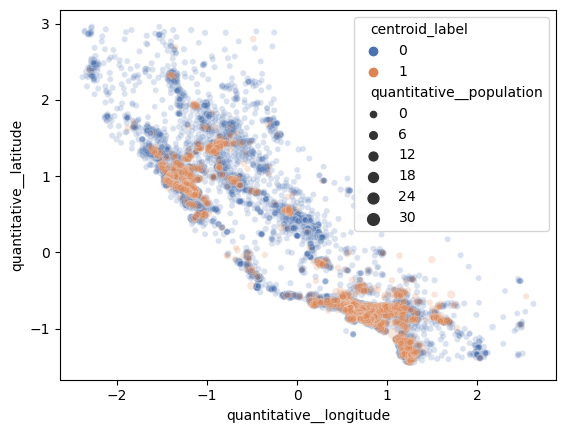

In [13]:
dfk2p2 = centroid_dataframe(sorted_pointsk2p2)
sns.scatterplot(dfk2p2, x="quantitative__longitude", y = "quantitative__latitude", 
                hue = 'centroid_label', alpha = 0.2, size='quantitative__population', palette="deep")

k = 2 seemes to cluster places that are more densely packed. We can see some semblance of rich areas in the orange area - Silicon valley and South Califorina.

<Axes: xlabel='quantitative__longitude', ylabel='quantitative__latitude'>

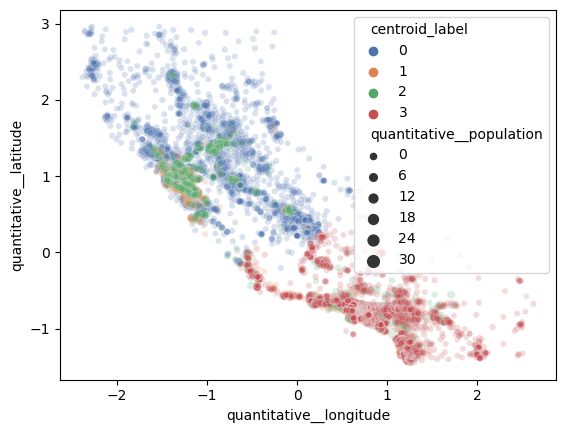

In [14]:
sorted_pointsk4p2, centroidsk4p2 = k_mean(4, 2, processed_data.to_numpy())
dfk4p2 = centroid_dataframe(sorted_pointsk4p2)
sns.scatterplot(dfk4p2, x="quantitative__longitude", y = "quantitative__latitude", 
                hue = 'centroid_label', alpha = 0.2, size='quantitative__population', palette="deep")

Her, we see a seperation of North and South with k = 4.

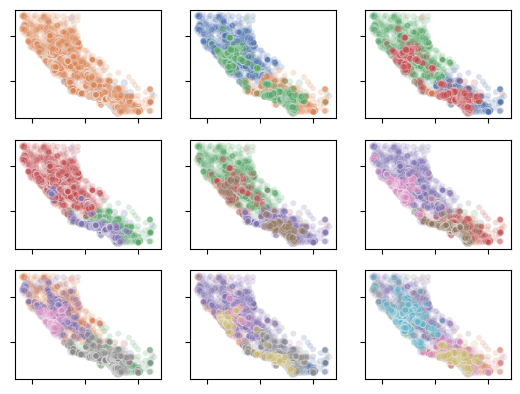

In [19]:
from sklearn.metrics import silhouette_score
fig,axes = plt.subplots(3,3)
silhouette_score_arr = []
iSTD = []
for i in range(2, 11):
    sorted_pointstemp, centroidstemp = k_mean(i, 2, processed_data.to_numpy())
    dftemp = centroid_dataframe(sorted_pointstemp)
    silhouette_score_arr.append(silhouette_score(dftemp.drop('centroid_label', axis= 1), dftemp['centroid_label'].to_numpy()))
    plt.xticks(visible=False)
    plt.yticks(visible=False)
    plt.legend('', frameon=False)
    plot = sns.scatterplot(ax = axes[(i-2) // 3, (i-2)%3],data = dftemp, x="quantitative__longitude", y = "quantitative__latitude", 
                hue = 'centroid_label', alpha = 0.2, size='quantitative__population', palette="deep", legend=False)
    plot.set(xticklabels=[])
    plot.set(xlabel=None)
    plot.set(yticklabels=[])
    plot.set(ylabel=None)
    i2, std2 = inertia_std(sorted_pointstemp, centroidstemp)
    iSTD.append((i2,std2))

From left to right and top to bottom, k has been varied from 2 to 10. It's hard to tell exactly what additional information that havg clusters give us. There are just too manypoints and color, even though we can see some sort of geographical clustering in most of these scatterplots. Furthermore, I used the silhouette library to give deeper analysis on the correct number of clusters.

<Axes: xlabel='k', ylabel='Inertia'>

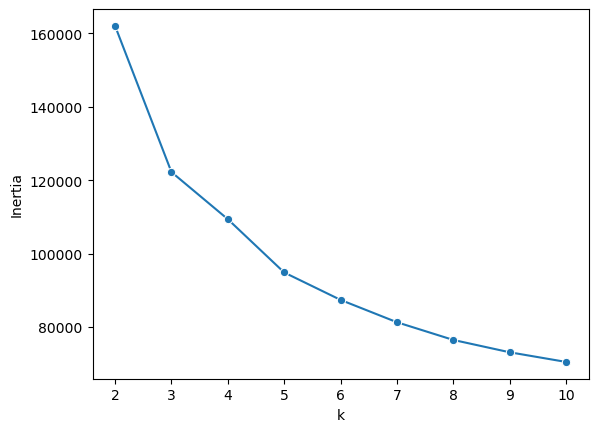

In [77]:
inertia_df_arr = []
for i in range(2,11):
    inertia_df_arr.append([i, iSTD[i-2][0]])
inertia_df = pd.DataFrame(inertia_df_arr, columns = ['k', 'Inertia'])
sns.lineplot(inertia_df, x= "k", y = "Inertia", marker = 'o')

In order to determine which value of k is good for splitting the data, we can look at the inertia graph. If I were to pick an elbow point, it would be either 5 or 6. However, it isn't so clear.

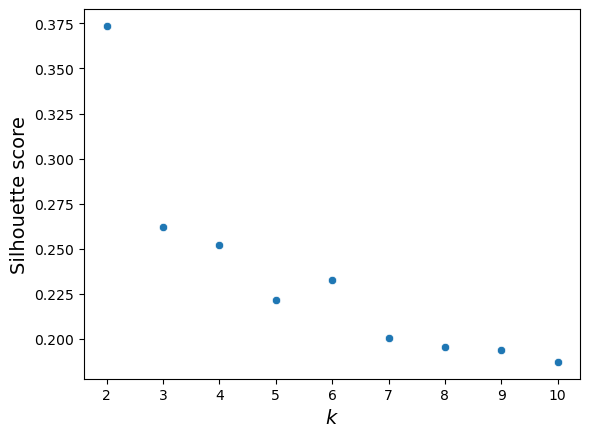

In [23]:
sns.scatterplot(y = silhouette_score_arr, x = np.array(range(2, 11)))
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.show()

It seems that with k = 2, the silhouette score is the best, meaning that there is the most information in that clustering. If we had to pick more clusters, k = 6 seems lie a good choice taking ito consideration the estimated elbow of the inertia graph.

- - -
## 4. WRITING ON THE INTUITION FOR THE CALIFORNIA HOUSING CRISIS (10 pts)





In this assignment, we used k-means to analyze the housing market in California. As k-means is an unsupervised method, our purpose was not prediction, but analysis. Therefore,exploratory data analysis before we applied k-means is very important as well as cluster analysis. Two things

1. We included longitude and latitude as features to train our model on. Therefore, our clustering does give some weight to geographical location. However, if our purpose is to look at where housing prices are highest and divide reigons mopre accurately based on value, including these two features may be detrimental to our analysis. Further extention of this assignment can look as the clusters when longitude, latitude, and ocean proximity are taken out.
2. We had colinearity in four of the features - namely household, total rooms, total bedrooms, and population. This means that they represent basically the same thing of how big the block is in terms of density. For our k-mean algorithm, this means that we would put four times the weight of normal variables on the desity of the block. Therefore, to remedy this, we could add all of the four variables after standarization and standardize it aga to make a density column, and then delete the four features from our analysis. This would give more accurate clustering.

From our analysis, we could see that  k = 2 and k = 6 were our best clusters. Looking at the graphs for both, we can see that thes graphs do the best when it come to dividing up the geographical blocks geographicaly. We also see emphasis on the SF and Silicon valley areas with roings of clusters around those areas. We can infer that higher value and dense blocks are concentrated in those areas. Perhaps the median houshold price is primarilly driven by the clusters in thoes area, while the vast majority of space in California is fine. We can use this inference to suggest that the different clusters refer to a general cost of living/urbanization of houses. For small businesses, they could use this information to move to areas not in the these hubspots, but on the border or not in thoes clusters at all.

- - -
### NEED HELP?

In case you get stuck in any step in the process, you may find some useful information from:

 * Consult my lectures and/or the textbook
 * Talk to the TA, they are available and there to help you during their OH.
 * Come talk to me or email me <nn4pj@virginia.edu> with subject starting "CS4774 Assignment 2:...".

Best of luck and have fun!